## Pixel-classification workflow


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image 
from pathlib import Path
import imutils
from imutils import paths

In [2]:
import gdal
import osgeo as osr
import geopandas as gpd
import numpy as np
import random
import shapefile as shp

In [3]:
def random_colour():
    colour=[]
    for _ in range(3):
        colour.append(random.randint(1, 255))
    return tuple(colour)


def geo2imagexy(dataset, x, y):
    trans = dataset.GetGeoTransform()
    a = np.array([[trans[1], trans[2]], [trans[4], trans[5]]])
    b = np.array([x - trans[0], y - trans[3]])
    return np.linalg.solve(a, b)

def getSRSPair(dataset):
    prosrs = osr.SpatialReference()
    prosrs.ImportFromWkt(dataset.GetProjection())
    geosrs = prosrs.CloneGeogCS()
    return prosrs, geosrs

def lonlat2geo(dataset, lon, lat):
    prosrs, geosrs = getSRSPair(dataset)
    ct = osr.CoordinateTransformation(geosrs, prosrs)
    coords = ct.TransformPoint(lon, lat)
    return coords[:2]

def run_png(tif_path,shp_path,out_path, classes):
    shape_data = gpd.read_file('./landcover_sample.dbf')
    tif_data = gdal.Open(tif_path)
    tif_datashape = tif_data.ReadAsArray()
    print(tif_datashape.shape)
    level_xiao=[]
    shapes=[]
    kkt = []
    for index, row in shape_data.iterrows():
        b = row['geometry']
        if b is None:
            continue
        if b.geom_type == "MultiPolygon":
            for pg in b:
                for j in pg.exterior.coords[:]:
                    #print("#"*20)
                    print(j)
                    (x,y,_)=j
                    #(xt,yt)=lonlat2geo(tif_data,x,y)
                    (xt,yt)=geo2imagexy(tif_data,x,y)
                    level_xiao.append((xt,yt))
                shapes.append(level_xiao)
                level_xiao=[]
        else:
            for ji in b.exterior.coords[:]:
                (x,y)=ji[0],ji[1]
                #(xt,yt)=lonlat2geo(tif_data,x,y)
                (xt,yt)=geo2imagexy(tif_data,x,y)
                level_xiao.append((xt,yt))
            shapes.append((level_xiao, row['land_type']))
            level_xiao=[]
    images = np.zeros((tif_datashape.shape[1],tif_datashape.shape[2],3))
    colours = {}
    for classname in classes:
        colour=random_colour()
        while colour in colours.values():
            colour=random_colour()
        colours[classname] = colour
        
    print(colours)
        
    for polygon, land_type in shapes:
        np_polygon=np.array([polygon], dtype=np.int32)
        
        cv.fillPoly(images,np_polygon,colours[land_type])
    cv.imwrite(out_path,images)
    print(np.unique(images,return_counts=True))
    return colours

In [7]:
sample = "./aerial_sampled2.tif"
satellite_image = cv.imread(sample)
satellite_image = cv.cvtColor(satellite_image, cv.COLOR_BGR2RGB)
#print(satellite_image.shape)

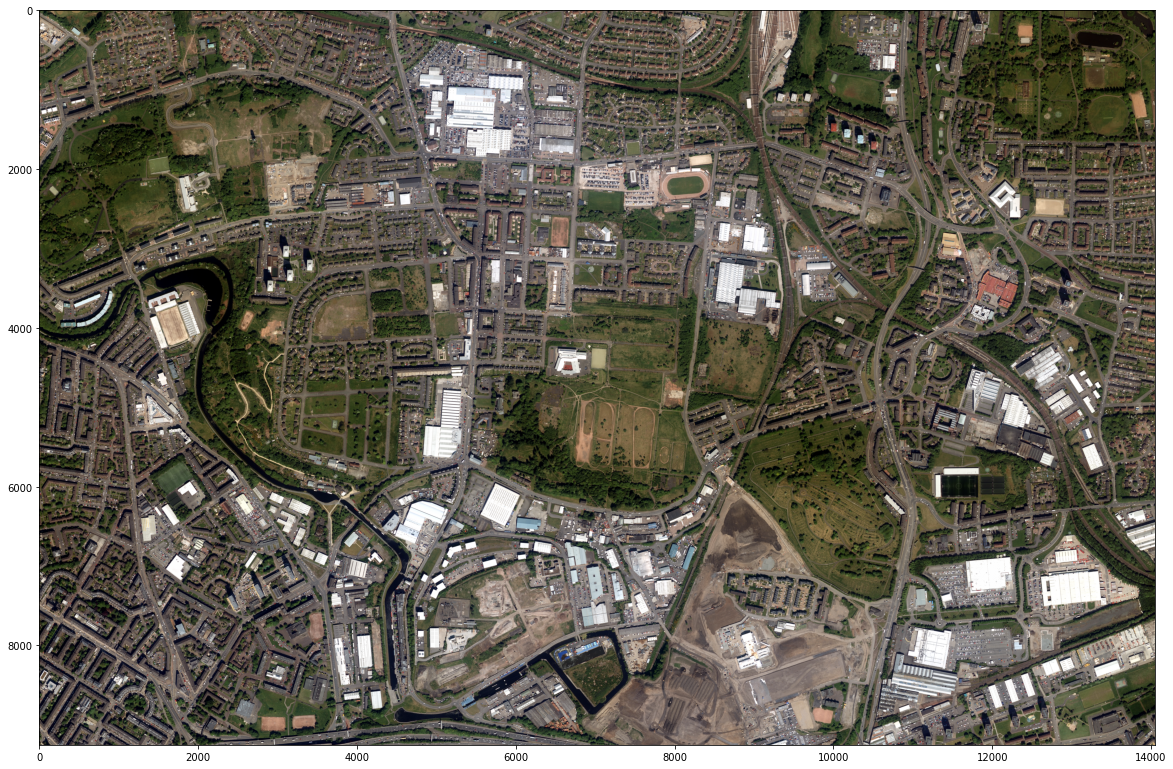

In [8]:
plt.figure(figsize = (20,20))
plt.imshow(satellite_image)
plt.savefig('sampled_satellite.png')

### Inspect the shapefile with the sampled classes

__gcs.csv download path:__ https://raw.githubusercontent.com/OSGeo/gdal/9fe5e1ec60f76c95176297f1a4c1099f0f7a5d3e/gdal/data/gcs.csv

In [5]:
sample_path='./landcover_sample.shp' 
#classes=ps.lib.io.open(sample_path)
sf = shp.Reader(sample_path)

In [6]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11, 11)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [7]:
sf

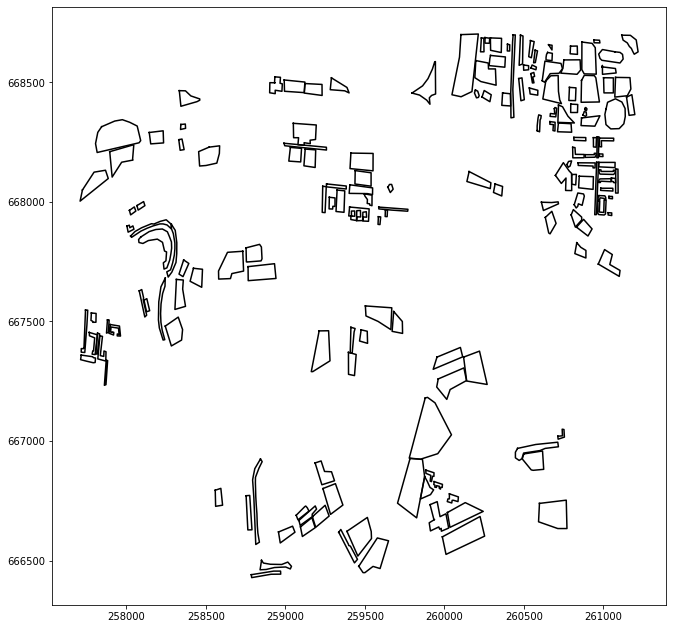

In [8]:
plot_map(sf)

In [9]:
classes_shp= gpd.read_file('./landcover_sample.dbf')

In [10]:
classes_df=pd.DataFrame(classes_shp)

In [11]:
classes_df.land_type.unique()

array(['water', 'bare soil', 'buildings', 'vegetation', 'concrete'],
      dtype=object)

In [15]:
colours_per_class = run_png('./aerial_sampled2.tif', # your cropped satellite image subset
        './landcover_sample.dbf', # the corresponding shapefile
        'per_class_mask.png',
        classes_df.land_type.unique()) # the mask output

(4, 9252, 14056)
{'water': (56, 226, 101), 'bare soil': (27, 231, 210), 'buildings': (186, 210, 186), 'vegetation': (131, 132, 169), 'concrete': (170, 179, 132)}
(array([  0.,  27.,  56., 101., 131., 132., 169., 170., 179., 186., 210.,
       226., 231.]), array([342759822,   5129937,    866099,    866099,   5678049,   7507993,
         5678049,   1829944,   1829944,   4577618,   7418746,    866099,
         5129937]))


In [16]:
colours_per_class

{'water': (56, 226, 101),
 'bare soil': (27, 231, 210),
 'buildings': (186, 210, 186),
 'vegetation': (131, 132, 169),
 'concrete': (170, 179, 132)}

In [20]:
per_class_mask_path = "./per_class_mask.png"
per_class_mask = cv.imread(per_class_mask_path, cv.COLOR_BGR2RGB)

In [22]:
alpha_channel = np.ones((*per_class_mask.shape[:2], 1))
per_class_masks_transparent = np.append(per_class_mask, alpha_channel, axis=2)
per_class_masks_transparent.shape

(9252, 14056, 4)

In [23]:
for i in range(per_class_masks_transparent.shape[0]):
    for j in range(per_class_masks_transparent.shape[1]):
        if np.all(per_class_masks_transparent[i, j, :] == [0, 0, 0, 1]):
            per_class_masks_transparent[i, j, :] = np.array([0, 0, 0, 0])

In [91]:
# per_class_mask = np.append(per_class_mask, np.ones((*per_class_mask.shape[:2], 1))*128, 2)

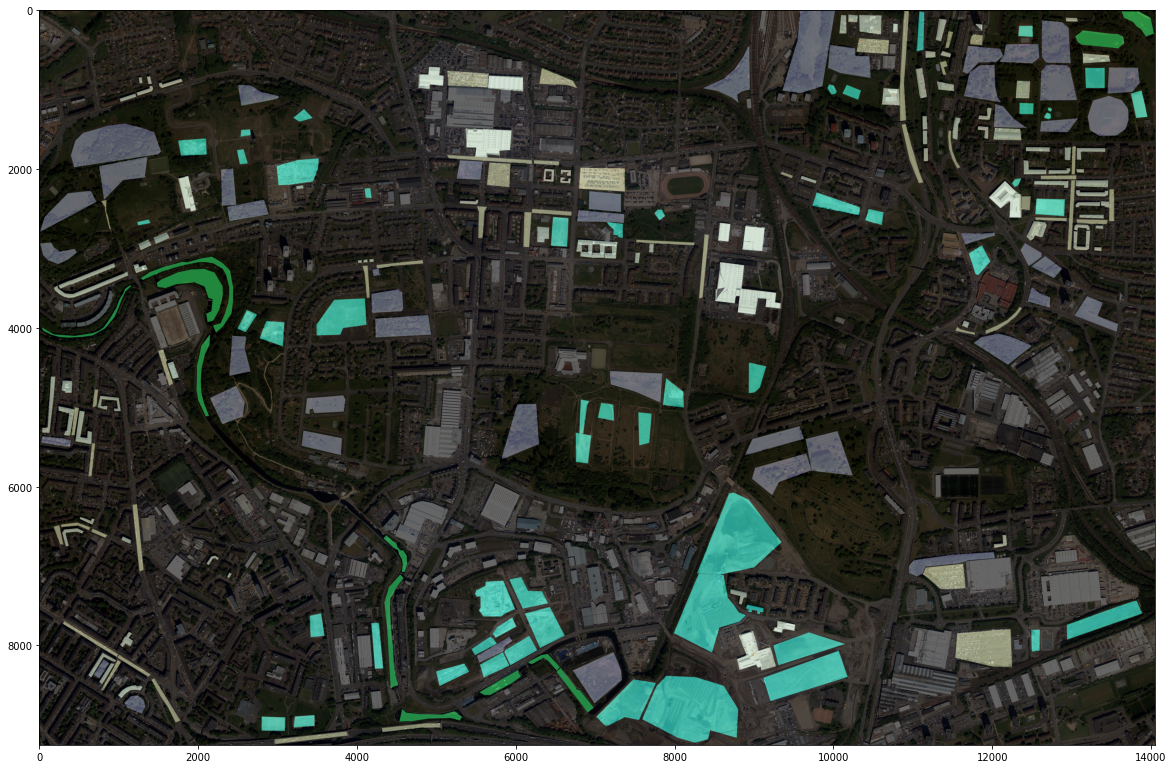

In [25]:
plt.figure(figsize = (20,20))
plt.imshow(satellite_image)
plt.imshow(per_class_mask, alpha=0.6)

In [99]:
img_shape = satellite_image.shape[:2]

In [106]:
def flatten_image(image):
    return image.reshape((image.shape[0] * image.shape[1], *image.shape[2:]))

In [107]:
flattened_sat_image = flatten_image(satellite_image)
flattened_class_image = flatten_image(per_class_mask)

In [108]:
flattened_sat_image.shape

(130046112, 3)

In [113]:
reverse_colour_map = {v: k for k, v in colours_per_class.items()}

In [120]:
output_data = pd.DataFrame({'R': pd.Series([], dtype='int'),
                   'G': pd.Series([], dtype='int'),
                   'B': pd.Series([], dtype='int'),
                   'class': pd.Series([], dtype='str')})

In [122]:
flattened_class_image

(130046112, 3)

In [147]:
larger_than_zero = [
    flattened_class_image[:, 0] > 0,
    flattened_class_image[:, 1] > 0,
    flattened_class_image[:, 2] > 0,
]

In [148]:
non_black_pixels = np.logical_and(np.logical_and(larger_than_zero[0], larger_than_zero[1]), larger_than_zero[2]).sum()

In [154]:
pixel_values = np.zeros((non_black_pixels, 3))
classes = np.empty([non_black_pixels], dtype='S10')

In [158]:
j = 0
for i in range(flattened_class_image.shape[0]):
    pixel_class_colour = tuple(flattened_class_image[i])
    if pixel_class_colour == (0, 0, 0):
        continue
    pixel_class = reverse_colour_map[pixel_class_colour]
    
    pixel_values[j] = np.array(flattened_sat_image[i])
    classes[j] = pixel_class
    j += 1

In [159]:
output_data['R'] = pixel_values[:, 0]
output_data['G'] = pixel_values[:, 1]
output_data['B'] = pixel_values[:, 2]
output_data['class'] = classes

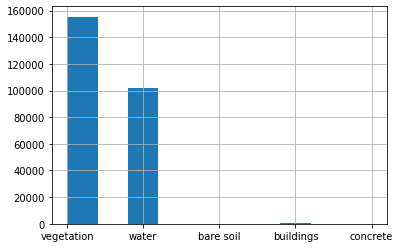

In [186]:
output_data[(output_data.R == 0) & (output_data.G == 0) & (output_data.B == 0)]['class'].hist()

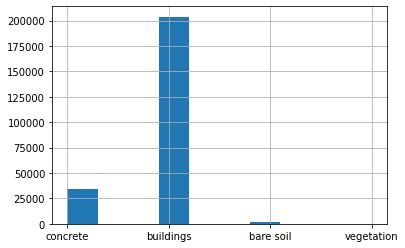

In [189]:
output_data[(output_data.R == 255) & (output_data.G == 255) & (output_data.B == 255)]['class'].hist()

In [163]:
reverse_colour_map

{(244, 201, 198): 'water',
 (160, 3, 13): 'bare soil',
 (155, 76, 10): 'buildings',
 (105, 130, 187): 'vegetation',
 (32, 222, 226): 'concrete'}

In [177]:
larger_than_zero_sat = [
    flattened_sat_image[:, 0] == 0,
    flattened_sat_image[:, 1] == 0,
    flattened_sat_image[:, 2] == 0,
]

In [178]:
np.logical_and(np.logical_and(larger_than_zero_sat[0], larger_than_zero_sat[1]), larger_than_zero_sat[2]).sum()

615895

In [188]:
output_data.to_pickle('./classification_dataset.pckl')